# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [4]:
import pandas as pd

import seaborn as sns
from seaborn import load_dataset

import patsy
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor



from skopt import BayesSearchCV

from mlxtend.feature_selection import SequentialFeatureSelector

In [5]:
df = pd.read_csv('previsao_de_renda.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.
8. Avalie a previsão mediana do log(renda) nas bases de treinamento e teste. A previsão mediana do log(renda), por hipótese, é o mesmo que a previsão média do log(renda).
9. Obtenha a previsão mediana da renda - a mediana é o exponencial do item anterior. Observe que para a média não vale o mesmo resultado.
10. Divida a previsão do item 9 em 10 grupos. Calcule a média, mediana, percentil 5% e percentil 95% da renda para cada grupo. Faça um gráfico.
Analise e comente as limitações dessa previsão, e reflita sobre o quão útil é este modelo.

#### Primeiramente o DataFrame será ajustado para poder trabalhar com dummies para que possa trabalhar melhor com os algoritimos de aprendizado e será removido algumas variáveis que não serão usadas.

In [7]:
# Mostrar todas colunas do DF
df.columns

Index(['Unnamed: 0', 'data_ref', 'id_cliente', 'sexo', 'posse_de_veiculo',
       'posse_de_imovel', 'qtd_filhos', 'tipo_renda', 'educacao',
       'estado_civil', 'tipo_residencia', 'idade', 'tempo_emprego',
       'qt_pessoas_residencia', 'renda'],
      dtype='object')

In [8]:
# Remover algumas colunas que não serão usadas
df.drop(columns=['Unnamed: 0', 'data_ref', 'id_cliente'], inplace=True)
df.columns

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda'],
      dtype='object')

In [9]:
# Guardando as colunas não numéricos
non_numeric = df.select_dtypes(include = ['object', 'bool']).columns
# Aplicando o get_dummies para transformar as colunas não numéricas em dummies (valores "bool", 0, 1)
df = pd.get_dummies(df, columns = non_numeric, dtype = int)
df.head(3)

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,sexo_F,sexo_M,posse_de_veiculo_False,posse_de_veiculo_True,posse_de_imovel_False,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,0,26,6.602740,1.0,8060.34,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
1,0,28,7.183562,2.0,1852.15,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,0,35,0.838356,2.0,2253.89,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   qtd_filhos                     15000 non-null  int64  
 1   idade                          15000 non-null  int64  
 2   tempo_emprego                  12427 non-null  float64
 3   qt_pessoas_residencia          15000 non-null  float64
 4   renda                          15000 non-null  float64
 5   sexo_F                         15000 non-null  int32  
 6   sexo_M                         15000 non-null  int32  
 7   posse_de_veiculo_False         15000 non-null  int32  
 8   posse_de_veiculo_True          15000 non-null  int32  
 9   posse_de_imovel_False          15000 non-null  int32  
 10  posse_de_imovel_True           15000 non-null  int32  
 11  tipo_renda_Assalariado         15000 non-null  int32  
 12  tipo_renda_Bolsista            15000 non-null 

In [11]:
# Acima no df.info já deu pra perceber que os valores não nulos de tempo_emprego estão diferentes.
# Verificando os valores faltantes do DF.
df.isnull().sum()

qtd_filhos                          0
idade                               0
tempo_emprego                    2573
qt_pessoas_residencia               0
renda                               0
sexo_F                              0
sexo_M                              0
posse_de_veiculo_False              0
posse_de_veiculo_True               0
posse_de_imovel_False               0
posse_de_imovel_True                0
tipo_renda_Assalariado              0
tipo_renda_Bolsista                 0
tipo_renda_Empresário               0
tipo_renda_Pensionista              0
tipo_renda_Servidor público         0
educacao_Primário                   0
educacao_Pós graduação              0
educacao_Secundário                 0
educacao_Superior completo          0
educacao_Superior incompleto        0
estado_civil_Casado                 0
estado_civil_Separado               0
estado_civil_Solteiro               0
estado_civil_União                  0
estado_civil_Viúvo                  0
tipo_residen

In [12]:
# Guardando o valor da média dos valores de tempo_emprego para preencher os valores vazios
mean_tempo_emprego = df['tempo_emprego'].mean()
mean_tempo_emprego

7.722634652121815

#### Os valores de tempo emprego nulo podem significar que são pessoas desempregadas, o que significaria o tempo de emprego igual a zero, mas como não há confirmação esses valores vão ser substituidos pela média, já que normalmente é um valor de referência para tirar outros parâmetros importantes.

In [13]:
# Trocando os valores nulos de tempo_emprego pela média
df['tempo_emprego'] = df['tempo_emprego'].fillna(mean_tempo_emprego)
# Verificando se tem algum valor nulo restante
df.isnull().sum().sum()

0

1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).

In [14]:
# Declarando X para guardar as colunas explicativas e y para variável target.
X = df.drop(columns=['renda'])
y = df['renda']

In [15]:
# Realizar a divisão em 75% para treinamento e 25% para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?

In [16]:
# Definindo os valores de alpha
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1]
# Criando um dicionário para guardar os valores de alpha como chave e r2 como valor da reg Ridge
squares_ridge = {}

''' Nesse laço de repetição todos valores da  lista alphas vão ser percorridos e será criado um 
Ridge para cada valor de alpha, logo depois é extraído o valor do R² com o score e guardado no dicionário'''
for alpha in alphas:
    reg = Ridge(alpha = alpha)
    reg.fit(X_train, y_train)
    r2 = reg.score(X_test, y_test)
    squares_ridge[alpha] = r2
print(squares_ridge)


{0: 0.25171921207979253, 0.001: 0.2514892015939013, 0.005: 0.2514893069878763, 0.01: 0.251489438588846, 0.05: 0.25149048578827504, 0.1: 0.2514917810128404}


In [17]:
best_r2_ridge = max(squares_ridge.values())
best_alpha_ridge = max(squares_ridge, key = squares_ridge.get)
print(f'Melhor ALPHA = {best_alpha_ridge}\nMelhor R² = {best_r2_ridge}')

Melhor ALPHA = 0
Melhor R² = 0.25171921207979253


3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?


In [18]:
# Criando um dicionário para guardar os valores de alpha como chave e r2 como valor da reg Lasso
squares_lasso = {}

''' Nesse laço de repetição todos valores da  lista alphas vão ser percorridos e será criado um 
Ridge para cada valor de alpha, logo depois é extraído o valor do R² com o score e guardado no dicionário'''
for alpha in alphas:
    reg = Lasso(alpha = alpha)
    reg.fit(X_train, y_train)
    r2 = reg.score(X_test, y_test)
    squares_lasso[alpha] = r2
print(squares_lasso)


C:\Users\Bill_\anaconda3\lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\Bill_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Bill_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.051e+11, tolerance: 8.293e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinat

{0: 0.25148907081781, 0.001: 0.25148934303646586, 0.005: 0.2514901910635573, 0.01: 0.251490868410159, 0.05: 0.25149860875999286, 0.1: 0.25150923145007054}


C:\Users\Bill_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.014e+10, tolerance: 8.293e+07
  model = cd_fast.enet_coordinate_descent(


In [19]:
best_r2_lasso = max(squares_lasso.values())
best_alpha_lasso = max(squares_lasso, key = squares_lasso.get)
print(f'Melhor ALPHA = {best_alpha_lasso}\nMelhor R² = {best_r2_lasso}')

Melhor ALPHA = 0.1
Melhor R² = 0.25150923145007054


#### Como obtive um monte de avisos sobre usar o alpha igual a zero, que faz com que meu lasso seja uma regressão comum e que pode levar a resultados inesperados, fiz uma novas regressões onde meu alpha que era zero agora está muito próximo de zero, porém não é zero. Além de incluir um maior numero de interações também devido aos avisos.

#### Os avisos continuaram, porém isso fez com que meu R² melhorasse um pouquinho.

In [20]:
# Definindo novos valores de alpha
alphas_2 = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]

# Criando um dicionário para guardar os valores de alpha como chave e r2 como valor da reg Lasso
squares_lasso = {}

''' Nesse laço de repetição todos valores da  lista alphas vão ser percorridos e será criado um 
ElasticNet com l1_ratio com valor para executar o Lasso para cada valor de alpha, 
logo depois é extraído o valor do R² com o score e guardado no dicionário'''
for alpha in alphas_2:
    reg = ElasticNet(alpha = alpha, max_iter=10000, l1_ratio = 1)
    reg.fit(X_train, y_train)
    r2 = reg.score(X_test, y_test)
    squares_lasso[alpha] = r2
print(squares_lasso)


C:\Users\Bill_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.580e+10, tolerance: 8.293e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\Bill_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.580e+10, tolerance: 8.293e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\Bill_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.581e+10, toleranc

{0.0001: 0.25148920247036766, 0.001: 0.25148935678374285, 0.005: 0.2514900789667466, 0.01: 0.2514912340940938, 0.05: 0.25150048027030136, 0.1: 0.2515120173634581}


In [21]:
best_r2_lasso = max(squares_lasso.values())
best_alpha_lasso = max(squares_lasso, key = squares_lasso.get)
print(f'Melhor ALPHA = {best_alpha_lasso}\nMelhor R² = {best_r2_lasso}')

Melhor ALPHA = 0.1
Melhor R² = 0.2515120173634581


4. Rode um modelo *stepwise*. Avalie o $R^2$ na base de testes. Qual o melhor resultado?


#### Aqui foi feito um stepwise bidirecional, ou seja, a medida que vai adicionando colunas, são feitas comparações, nesse caso com o P Value >= 0.05 e se esse valor é maior então é removida a coluna. As colunas foram adicionadas com base no panda series criada com o p_values_crescente que retorna os index(as colunas) de forma crescente dos P Value do modelo na base de testes. Note que foi usado o conjunto de dados de df_wise na nova divisão de treino e teste.

In [22]:
# Criando o modelo a para coletar os P Value
modelo = sm.OLS(y, X).fit()
# Criando um Panda Series para guardar os valores de P e suas colunas
p_values = modelo.pvalues
# Criando um novo Panda Series que salva todas colunas de forma ordenada do menor P para o maior
p_values_crescente = p_values.sort_values().index
p_values_crescente

Index(['tempo_emprego', 'sexo_F', 'sexo_M', 'idade', 'tipo_renda_Pensionista',
       'tipo_renda_Empresário', 'educacao_Superior incompleto',
       'posse_de_imovel_False', 'estado_civil_União',
       'educacao_Superior completo', 'estado_civil_Separado',
       'qt_pessoas_residencia', 'estado_civil_Viúvo', 'tipo_residencia_Casa',
       'tipo_residencia_Com os pais', 'qtd_filhos', 'posse_de_veiculo_False',
       'posse_de_veiculo_True', 'tipo_residencia_Governamental',
       'tipo_renda_Servidor público', 'educacao_Secundário',
       'estado_civil_Casado', 'educacao_Primário', 'tipo_renda_Assalariado',
       'tipo_residencia_Comunitário', 'tipo_renda_Bolsista',
       'estado_civil_Solteiro', 'posse_de_imovel_True',
       'tipo_residencia_Estúdio', 'educacao_Pós graduação',
       'tipo_residencia_Aluguel'],
      dtype='object')

In [23]:
# Criando DF para usar no looping
df_wise = pd.DataFrame()

for var in p_values_crescente:
    df_wise[var] = X[var] #Adicionando a variável da lista crescente (dos value P)
    modelo_wise = sm.OLS(y, df_wise).fit() #Criando a reg pra tirar o novo valor P
    p_values_wise = modelo_wise.pvalues #Obtendo os novos P value
    p_values_filtrado = p_values[p_values>=0.05] #Obtendo colunas com P value alto, para remover
    for col in p_values_filtrado.index: #Looping para percorrer os indices de p_values_filtrado
        if col in df_wise.columns: #Se o indice de p_values_filtrado estiver nas colunas de df_wise
            df_wise.drop(col, axis=1, inplace=True) #Deleta aquela coluna que está entre os P value >=0.05
    
    
df_wise

,tempo_emprego,sexo_F,sexo_M,idade,tipo_renda_Pensionista,tipo_renda_Empresário
0,6.602740,1,0,26,0,1
1,7.183562,0,1,28,0,0
2,0.838356,1,0,35,0,1
3,4.846575,1,0,30,0,0
4,4.293151,0,1,33,0,0
...,...,...,...,...,...,...
14995,13.887671,1,0,48,0,1
14996,7.722635,1,0,57,1,0
14997,7.832877,1,0,45,0,0
14998,4.298630,0,1,36,0,1


#### Criado uma nova regressão após o stepwise e foi obtido um R² de 0.258, ligeiramente melhor do que o obtido com o Lasso e Ridge

In [24]:
# Dividindo novamente os dados em treino e teste, só que dessa vez usando o conjunto de dados de df_wise
X_train_wise, X_test_wise, y_train_wise, y_test_wise = train_test_split(df_wise, y, test_size=0.25, random_state=1)

modelo_wise = sm.OLS(y_test_wise, X_test_wise).fit()
modelo_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     260.5
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          1.50e-239
Time:                        10:04:14   Log-Likelihood:                -38081.
No. Observations:                3750   AIC:                         7.617e+04
Df Residuals:                    3744   BIC:                         7.621e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
tempo_emprego            493.5944     17.888     27.594      0.000     458.523     528.666
sexo_F                  -442.2864    530.530     -0.834      0.405   -1482.442     597.869
sexo_M                  4858.1862    503.492      9.649      0.000    3871.042    5845.331
idade                     10.1295     12.433      0.815      0.415     -14.247      34.506
tipo_renda_Pensionista  -909.2943    356.852     -2.548      0.011   -1608.938    -209.651
tipo_renda_Empresário   1101.9351    250.511      4.399      0.000     610.784    1593.087
==============================================================================
Omnibus:                     4489.464   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           942906.207
Skew:                           6.106   Prob(JB):                         0.00
Kurtosis:                      79.717   Cond. No.                         334.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?


O último modelo com stepwise teve um resultado de R² melhor do que os demais e está usando apenas as variáveis estatistacamente relevantes, além de estar rodando com conjunto de testes, porém é difícil dizer qual é o melhor, seria útil fazer uma validação cruzada e explorar um pouco mais.

6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.


In [25]:
# Guardando os valores preditos 
y_pred_wise = modelo_wise.predict(X_test_wise)
# Calculando diferença do dado real pro dado predito
residuos = y_test_wise - y_pred_wise

#### Aqui será avaliado um gráfico de resíduos para verificar como está se comportando os outliers

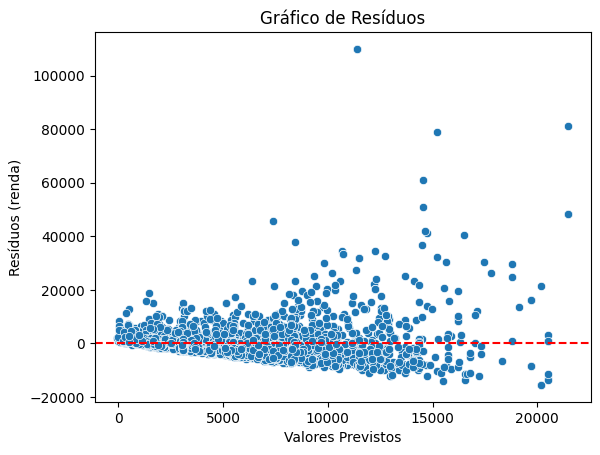

In [26]:
sns.scatterplot(x=y_pred_wise, y=residuos)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos (renda)')
plt.title('Gráfico de Resíduos')
plt.show()

#### Alguns dados estão muito distantes da média e isso parece se intensificar a medida que a reta avança, como está sendo tratado um valor em dinheiro que pode ser facilmente escalonado, será alterado o valor da variável resposta para log e verificar essa nova relação.
#### -
##### Acabei mantendo os nomes das variáveis porque começaria a ficar um nome muito extenso.

In [27]:
# Criando a coluna da resposta do y em log
y_log = np.log(y)
# Dividindo novamente em treino e teste para y com valor em log
X_train_wise, X_test_wise, y_train_wise, y_test_wise = train_test_split(
                                                        df_wise, y_log, test_size=0.25, random_state=1)

In [28]:
# Nesse modelo a diferença é que os dados de treino e teste agora foram comparados com y em LOG
modelo_wise = sm.OLS(y_test_wise, X_test_wise).fit()
modelo_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     338.5
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          6.50e-300
Time:                        10:04:14   Log-Likelihood:                -4103.3
No. Observations:                3750   AIC:                             8219.
Df Residuals:                    3744   BIC:                             8256.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
tempo_emprego              0.0602      0.002     28.989      0.000       0.056       0.064
sexo_F                     7.3430      0.062    119.171      0.000       7.222       7.464
sexo_M                     8.1045      0.058    138.591      0.000       7.990       8.219
idade                      0.0034      0.001      2.383      0.017       0.001       0.006
tipo_renda_Pensionista    -0.1596      0.041     -3.851      0.000      -0.241      -0.078
tipo_renda_Empresário      0.1887      0.029      6.486      0.000       0.132       0.246
==============================================================================
Omnibus:                        2.661   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.264   Jarque-Bera (JB):                2.595
Skew:                          -0.058   Prob(JB):                        0.273
Kurtosis:                       3.057   Cond. No.                         334.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

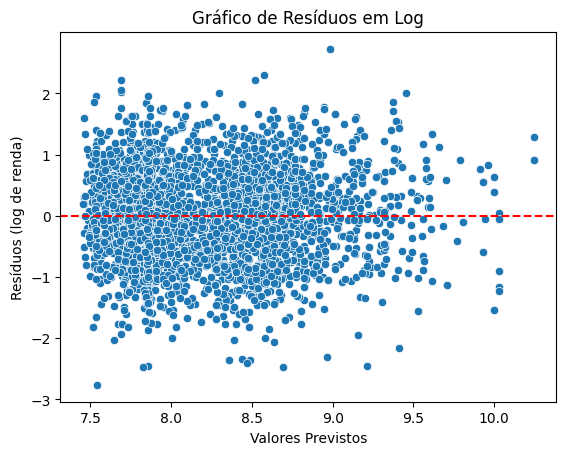

In [29]:
# Guardando os valores preditos
y_pred_wise = modelo_wise.predict(X_test_wise)
# Calculando diferença do dado real pro dado predito
residuos = y_test_wise - y_pred_wise

sns.scatterplot(x=y_pred_wise, y=residuos)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos (log de renda)')
plt.title('Gráfico de Resíduos em Log')
plt.show()

7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.


#### Foi obtido um valor quase que semelhante ao resultado anterior na base de teste, porém a base de treino está com um valor muito melhor, o que indica um overfitting. Lembrando que os valores de y continuam em log.

In [30]:
# Criando a árvore de regressão
arvore_reg = DecisionTreeRegressor(random_state = 1)
# Ajustando a árvore de regressão com os dados de treino
arvore_reg.fit(X_train_wise, y_train_wise)

# Predição dos dados de treino e teste
y_pred_train = arvore_reg.predict(X_train_wise)
y_pred_test = arvore_reg.predict(X_test_wise)

# Comparando com o "gabarito" para calcular o R²
r2_treino = r2_score(y_train_wise, y_pred_train)
r2_teste = r2_score(y_test_wise, y_pred_test)

print(f"R² treino: {r2_treino}\nR² teste: {r2_teste}")

R² treino: 0.695212941882947
R² teste: 0.30729340852698006


#### Será utilizado a Otimização Bayesiana para definir melhor profundidade e número minimo de folhas

In [31]:
# Declarando uma variável para obter informações da árvore de regressão já criada
arvore_infos = arvore_reg.tree_

# Obtendo a profundidade máxima da árvore
profundidade_maxima = arvore_infos.max_depth
profundidade_maxima

28

In [32]:
'''Para se ajustar o minimo de amostras de uma maneira proporcional, 
será passado os valores em porcentagem'''
# Guardando o tamanho total de amostras no amostras_total
amostras_total = len(X_train_wise)
# Definindo o minimo da faixa de valores do minimo de amostras a ser aceito na arvore
min_samples_minimo = int(amostras_total * 0.01) # Definindo em 1%
# Definindo o máximo da faixa de valores do minimo de amostras a ser aceita na arvore
min_samples_maximo = int(amostras_total * 0.10) #Definindo em 10%


# Definir os hiperparâmetros e suas faixas de busca
parametros = {
    'max_depth': (1, profundidade_maxima), # Faixa de valores da profundidade máxima
    'min_samples_split': (min_samples_minimo, min_samples_maximo), # Faixa de valores do minimo de amostras aceita na arvore
}

parametros

{'max_depth': (1, 28), 'min_samples_split': (112, 1125)}

#### Aqui foi obtido um resultado melhor de R² em 35% ao utilizar 10 arvores

In [33]:
# Criando uma nova árvore vazia (sem o fit)
arvore_bay = RandomForestRegressor(n_estimators = 10, random_state = 1)

'''Declarando a otimização usando a arvore_bay e os parametros declarados acima, 
o valor de 50 vai ser o número de iterações e o cv=5 é a quantidade de porções que 
os dados de treino e teste serão divididos, então as iterações vão ser feitas com
5 dividões de testes diferentes'''
otimizacao_bayesiana = BayesSearchCV(arvore_bay, parametros, n_iter = 50, cv = 5)
otimizacao_bayesiana.fit(X_train_wise, y_train_wise)

# Obtendo a melhor profundidade
melhor_profundidade = otimizacao_bayesiana.best_params_['max_depth']
# Obtendo o melhor minimo de amostras para uma divisão de nó
melhor_min_samples_split = otimizacao_bayesiana.best_params_['min_samples_split']

# Treinar o modelo com os melhores hiperparâmetros obtidos com os passos anteriores
melhor_arvore_bay = RandomForestRegressor(n_estimators = 10, max_depth = melhor_profundidade, 
                                             min_samples_split = melhor_min_samples_split, random_state = 1)
melhor_arvore_bay.fit(X_train_wise, y_train_wise)

# Fazendo predição nos dados de teste (substituindo o valor da ultima predição)
y_pred_test = melhor_arvore_bay.predict(X_test_wise)
# Salvando a predição de treino para usar no próximo exercício
y_pred_train = melhor_arvore_bay.predict(X_train_wise)

# Calculando o R² para os dados de teste (substituindo o valor do ultimo score)
r2_teste = r2_score(y_test_wise, y_pred_test)
r2_treino = r2_score(y_train_wise, y_pred_train)

print(f"Melhor profundidade: {melhor_profundidade}")
print(f"Melhor min_samples_split: {melhor_min_samples_split}")
print(f"R² nos dados de teste: {r2_teste:.4f}")
print(f"R² nos dados de treino: {r2_treino:.4f}")

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

8. Avalie a previsão mediana do log(renda) nas bases de treinamento e teste. A previsão mediana do log(renda), por hipótese, é o mesmo que a previsão média do log(renda).


#### Os valores da mediana e da média do log deram bem próximos, mas não foram os mesmos valores.

In [ ]:
# Adiquirindo as medianas de treino e teste
mediana_treino_y_log = np.median(y_pred_train)
mediana_teste_y_log = np.median(y_pred_test)

print(f"Mediana treino: {mediana_treino_y_log}")
print(f"Mediana teste: {mediana_teste_y_log}")

In [ ]:
# Adiquirindo as medias de treino e teste
media_treino_y_log = np.mean(y_pred_train)
media_teste_y_log = np.mean(y_pred_test)

print(f"Media treino: {media_treino_y_log}")
print(f"Media teste: {media_teste_y_log}")

9. Obtenha a previsão mediana da renda - a mediana é o exponencial do item anterior. Observe que para a média não vale o mesmo resultado.
mediana_y


In [ ]:
# Transformando os valores adiquiridos anteriormente para o original de Y
mediana_treino_y_normal = np.exp(mediana_treino_y_log)
mediana_teste_y_normal = np.exp(mediana_teste_y_log)

print(f"Mediana treino: {mediana_treino_y_normal}")
print(f"Mediana teste: {mediana_teste_y_normal}")

# -----

media_treino_y_normal = np.exp(media_treino_y_log)
media_teste_y_normal = np.exp(media_teste_y_log)

print(f"Media treino: {media_treino_y_normal}")
print(f"Media teste: {media_teste_y_normal}")

10. Divida a previsão do item 9 em 10 grupos. Calcule a média, mediana, percentil 5% e percentil 95% da renda para cada grupo. Faça um gráfico.
Analise e comente as limitações dessa previsão, e reflita sobre o quão útil é este modelo.

In [ ]:
# Colocando a predição para o valor original
y_pred_test_normal = np.exp(y_pred_test)
y_pred_test_normal

In [ ]:
# Dividindo meus valores preditos em 10 grupos com o array_split do numpy
y_pred_test_normal_grupos = np.array_split(y_pred_test_normal, 10)
# Declarando as listas para guardar os valores
medias = []
medianas = []
percentil_5 = []
percentil_95 = []

''' Nesse for vai ser percorrido todas arrays criadas anteriormente (os 10 grupos) e vai ser guardado
esses valores em suas respectivas listas'''
for i in range(10):
    medias.append(np.mean(y_pred_test_normal_grupos[i]))
    medianas.append(np.median(y_pred_test_normal_grupos[i]))
    percentil_5.append(np.percentile(y_pred_test_normal_grupos[i], 5))
    percentil_95.append(np.percentile(y_pred_test_normal_grupos[i], 95))

print(f'VALORES DA MEDIA DE CADA GRUPO \n{medias}\n')
print(f'VALORES DA MEDIANA DE CADA GRUPO \n{medianas}\n')
print(f'VALORES DO PERCENTIL 5% DE CADA GRUPO \n{percentil_5}\n')
print(f'VALORES DO PERCENTIL 95% DE CADA GRUPO \n{percentil_95}')



In [ ]:
''' Aqui foi declarado um dicionário, sua chave representa os grupos e os valores são 
os 5% menores valores separados pelo porcentil'''
valores_p5 = {}
for i in range(len(y_pred_test_normal_grupos)):
    valores = []
    for y_pred_valor in y_pred_test_normal_grupos[i]:
        if y_pred_valor <= percentil_5[i]:
            valores.append(y_pred_valor)
    valores_p5[i] = valores

'''Percorrendo o dicionário para ter uma noção da quantidade dos valores abaixo de 5%
e verificando se está homogênio em seus resultados'''
for i in range(len(valores_p5)):
    print(f"Quantidade de valores abaixo de 5% no {i}º grupo: {len(valores_p5[i])}")

In [ ]:
''' Aqui foi declarado um dicionário, sua chave representa os grupos e os valores são 
os 5% menores valores separados pelo porcentil'''
valores_p95 = {}
for i in range(len(y_pred_test_normal_grupos)):
    valores = []
    for y_pred_valor in y_pred_test_normal_grupos[i]:
        if y_pred_valor >= percentil_95[i]:
            valores.append(y_pred_valor)
    valores_p95[i] = valores

'''Percorrendo o dicionário para ter uma noção da quantidade dos valores acima de 95%
e verificando se está homogênio em seus resultados'''
for i in range(len(valores_p95)):
    print(f"Quantidade de valores acima de 95% no {i}º grupo: {len(valores_p95[i])}")
    


#### Abaixo foi feito um gráfico para representar os valores em LOG

In [ ]:
# Criar uma figura e um eixo
fig, ax = plt.subplots()

# Gráfico de regressão da reta com cor vermelha
sns.regplot(x=y_test_wise, y=y_pred_test, scatter=False, color='red', label='Regressão', ax=ax)

# Gráfico de dispersão dos dados de teste com cor azul
sns.scatterplot(x=y_test_wise, y=y_pred_test, color='blue', label='Dados de Teste', ax=ax)

# Personalizando o gráfico
plt.xlabel('Valores Reais (y_test_wise)')
plt.ylabel('Valores Previstos (y_pred_test_normal)')
plt.title('Gráfico de Regressão dos Dados de Teste (Escala LOG)')
plt.legend()

# Exibir o gráfico
plt.show()

#### Já nesse caso ficou com os valores normais, voltando o y_test_wise para o valor original

In [ ]:
# Criar uma figura e um eixo
fig, ax = plt.subplots()

# Gráfico de regressão da reta com cor vermelha
sns.regplot(x=np.exp(y_test_wise), y=y_pred_test_normal, scatter=False, color='red', label='Regressão', ax=ax)

# Gráfico de dispersão dos dados de teste com cor azul
sns.scatterplot(x=np.exp(y_test_wise), y=y_pred_test_normal, color='blue', label='Dados de Teste', ax=ax)

# Personalizando o gráfico
plt.xlabel('Valores Reais (y_test_wise)')
plt.ylabel('Valores Previstos (y_pred_test_normal)')
plt.title('Gráfico de Regressão dos Dados de Teste (Escala Normal)')
plt.legend()

# Exibir o gráfico
plt.show()

#### A divisão dos valores em grupos pode ser bem útil para verificar a quantidade de valores que podem estar como outliers ou muito acima ou muito abaixo da média e definir uma medida a ser aplicada no modelo para tratar os outliers, também ajuda a ver se os valores estão homogênios ou não, como na divisão dos grupos a quantidade de todos foi quase que igual da para perceber que os valores tanto abaixo de 5% quanto acima de 95% estão bem balanceados nos 10 grupos.